# ノートブック19: Store Demand時系列予測 - GBDT×時系列の完全ガイド ⏰

**学習目標**: 時系列データでGBDTを使い、SMAPE < 15%を達成

---

## 📋 このノートブックで学ぶこと

### 1. 時系列データの基礎 ⭐⭐⭐
- Trend（トレンド）、Seasonality（季節性）、Residuals（残差）の分解
- Autocorrelation（自己相関）の理解
- 時系列データの可視化

### 2. 時系列特徴量エンジニアリング ⭐⭐⭐
- Lag features（ラグ特徴量）: 1日前、7日前、30日前...
- Rolling window statistics（移動窓統計量）
- 周期性のエンコード（曜日、月、祝日）
- Fourier features（フーリエ特徴量）

### 3. 時系列のモデリング ⭐⭐⭐
- Temporal split（時間分割）
- Walk-forward validation
- GBDT for time series
- Multi-step forecasting

### 4. 評価指標 ⭐⭐
- SMAPE (Symmetric Mean Absolute Percentage Error)
- MAE, RMSE for time series

---

## 🎯 目標

- **SMAPE**: < 15%
- **Kaggle Store Item Demand**: Top 25%

---

In [1]:
# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime, timedelta

# 時系列分析
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 機械学習
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# GBDT
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# 設定
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('tab10')
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ セットアップ完了")

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


✅ セットアップ完了


## 📊 1. データ読み込みとEDA

In [2]:
# データディレクトリ
data_dir = Path('../data/store_demand')
data_dir.mkdir(parents=True, exist_ok=True)

try:
    train = pd.read_csv(data_dir / 'train.csv', parse_dates=['date'])
    test = pd.read_csv(data_dir / 'test.csv', parse_dates=['date'])
    print("✅ データ読み込み成功")
except FileNotFoundError:
    print("⚠️ デモ用の時系列データを生成")
    # デモ用データ生成
    dates = pd.date_range(start='2013-01-01', end='2017-12-31', freq='D')
    n_stores = 10
    n_items = 50
    
    data_list = []
    for store in range(1, n_stores + 1):
        for item in range(1, n_items + 1):
            # トレンド + 季節性 + ノイズ
            trend = np.linspace(10, 50, len(dates))
            seasonality = 20 * np.sin(np.arange(len(dates)) * 2 * np.pi / 365.25)
            weekly = 10 * np.sin(np.arange(len(dates)) * 2 * np.pi / 7)
            noise = np.random.normal(0, 5, len(dates))
            sales = np.maximum(0, trend + seasonality + weekly + noise + store * 2 + item)
            
            df_temp = pd.DataFrame({
                'date': dates,
                'store': store,
                'item': item,
                'sales': sales
            })
            data_list.append(df_temp)
    
    train = pd.concat(data_list, ignore_index=True)
    # テストデータ（次の3ヶ月）
    test_dates = pd.date_range(start='2018-01-01', end='2018-03-31', freq='D')
    test = pd.DataFrame({
        'date': np.tile(test_dates, n_stores * n_items),
        'store': np.repeat(np.arange(1, n_stores + 1), len(test_dates) * n_items),
        'item': np.tile(np.repeat(np.arange(1, n_items + 1), len(test_dates)), n_stores)
    })

print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nDate range: {train['date'].min()} to {train['date'].max()}")

# 最初の数行
display(train.head(10))

⚠️ デモ用の時系列データを生成



Train shape: (913000, 4)
Test shape: (45000, 3)

Date range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00


,date,store,item,sales
0,2013-01-01,1,1,15.483571
1,2013-01-02,1,1,20.492943
2,2013-01-03,1,1,26.719519
3,2013-01-04,1,1,26.051427
4,2013-01-05,1,1,8.953175
5,2013-01-06,1,1,3.907747
6,2013-01-07,1,1,15.269884
7,2013-01-08,1,1,19.393122
8,2013-01-09,1,1,21.389993
9,2013-01-10,1,1,28.743421


### 1.1 時系列の可視化

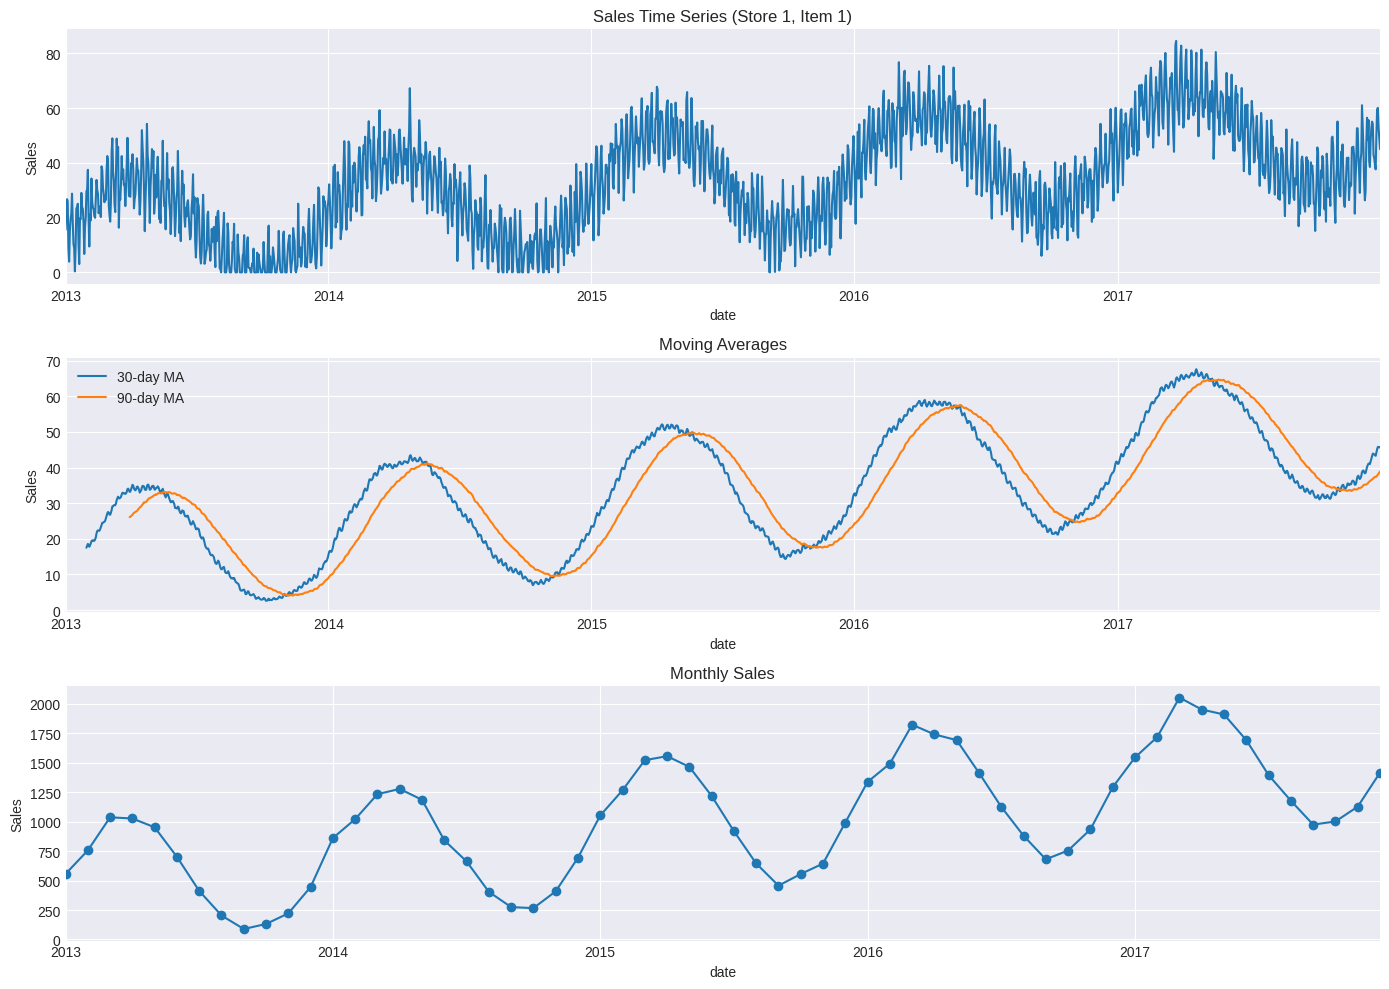

In [3]:
# 1つの店舗・商品の時系列を可視化
sample = train[(train['store'] == 1) & (train['item'] == 1)].copy()
sample = sample.set_index('date')['sales']

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. 元の時系列
sample.plot(ax=axes[0])
axes[0].set_title('Sales Time Series (Store 1, Item 1)')
axes[0].set_ylabel('Sales')

# 2. 移動平均
sample.rolling(window=30).mean().plot(ax=axes[1], label='30-day MA')
sample.rolling(window=90).mean().plot(ax=axes[1], label='90-day MA')
axes[1].set_title('Moving Averages')
axes[1].set_ylabel('Sales')
axes[1].legend()

# 3. 月次集計
monthly = sample.resample('M').sum()
monthly.plot(ax=axes[2], marker='o')
axes[2].set_title('Monthly Sales')
axes[2].set_ylabel('Sales')

plt.tight_layout()
plt.show()

### 1.2 季節性分解

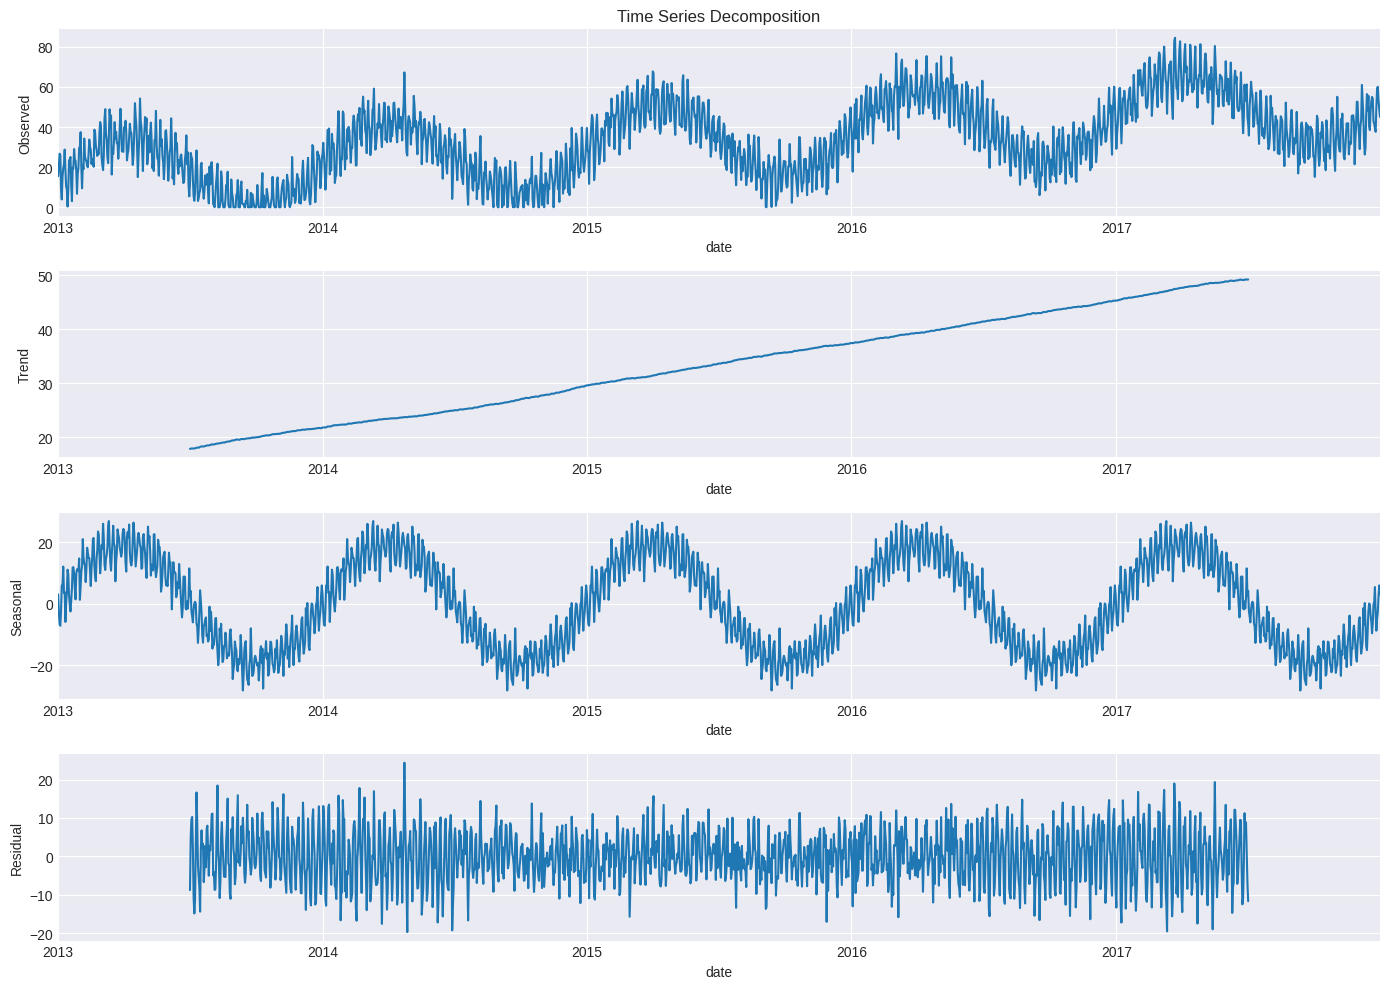

In [4]:
# 季節性分解（加法モデル）
decomposition = seasonal_decompose(sample, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

decomposition.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
axes[0].set_title('Time Series Decomposition')

decomposition.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

### 1.3 自己相関分析

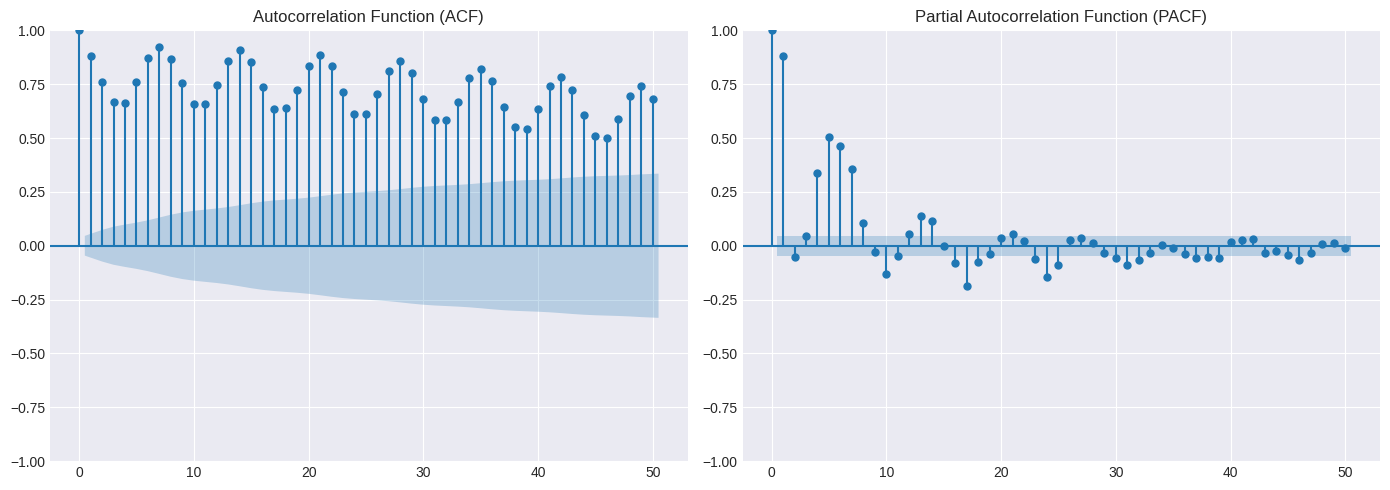


📊 ACF/PACFから、有意なラグ（lag）を特定できます
   - 7日ラグ: 週次パターン
   - 30日ラグ: 月次パターン
   - 365日ラグ: 年次パターン


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
plot_acf(sample.dropna(), lags=50, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF
plot_pacf(sample.dropna(), lags=50, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

print("\n📊 ACF/PACFから、有意なラグ（lag）を特定できます")
print("   - 7日ラグ: 週次パターン")
print("   - 30日ラグ: 月次パターン")
print("   - 365日ラグ: 年次パターン")

## 🔨 2. 時系列特徴量エンジニアリング ⭐⭐⭐

In [6]:
def create_time_series_features(df):
    """
    時系列特徴量の作成
    """
    df = df.copy()
    
    # 日付特徴量
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    
    # 週末フラグ
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # 月初・月末フラグ
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    
    # 周期性の正弦・余弦エンコーディング
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    print(f"✅ 時系列特徴量作成完了: {df.shape[1]} 特徴量")
    return df

# 特徴量作成
train = create_time_series_features(train)
test = create_time_series_features(test)

✅ 時系列特徴量作成完了: 20 特徴量
✅ 時系列特徴量作成完了: 19 特徴量


### 2.1 Lag Features（ラグ特徴量） ⭐⭐⭐

In [7]:
def create_lag_features(df, lags=[1, 7, 14, 28, 30, 60, 90]):
    """
    Lag features（過去の売上）の作成
    """
    df = df.copy()
    df = df.sort_values(['store', 'item', 'date'])
    
    if 'sales' in df.columns:
        for lag in lags:
            df[f'sales_lag_{lag}'] = df.groupby(['store', 'item'])['sales'].shift(lag)
    
    print(f"✅ Lag特徴量作成: {len(lags)} lags")
    return df

# Train データにLag特徴量を追加
train = create_lag_features(train, lags=[1, 7, 14, 28, 30, 60, 90])

✅ Lag特徴量作成: 7 lags


### 2.2 Rolling Window Statistics（移動窓統計量） ⭐⭐⭐

In [8]:
def create_rolling_features(df, windows=[7, 14, 30, 60, 90]):
    """
    Rolling window statistics
    """
    df = df.copy()
    df = df.sort_values(['store', 'item', 'date'])
    
    if 'sales' in df.columns:
        for window in windows:
            # Rolling mean
            df[f'sales_rolling_mean_{window}'] = (
                df.groupby(['store', 'item'])['sales']
                .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
            )
            
            # Rolling std
            df[f'sales_rolling_std_{window}'] = (
                df.groupby(['store', 'item'])['sales']
                .transform(lambda x: x.rolling(window=window, min_periods=1).std())
            )
            
            # Rolling max/min
            df[f'sales_rolling_max_{window}'] = (
                df.groupby(['store', 'item'])['sales']
                .transform(lambda x: x.rolling(window=window, min_periods=1).max())
            )
            df[f'sales_rolling_min_{window}'] = (
                df.groupby(['store', 'item'])['sales']
                .transform(lambda x: x.rolling(window=window, min_periods=1).min())
            )
    
    print(f"✅ Rolling特徴量作成: {len(windows)} windows")
    return df

# Rolling特徴量追加
train = create_rolling_features(train, windows=[7, 14, 30])

✅ Rolling特徴量作成: 3 windows


## 🎯 3. データ準備

### ⚠️ 重要: 時系列データではシャッフルしない！

In [9]:
# 特徴量とターゲットの分離
feature_cols = [col for col in train.columns if col not in ['date', 'sales']]
X = train[feature_cols]
y = train['sales']

# 欠損値補完（Lag特徴量で発生）
X = X.fillna(0)

print(f"✅ データ準備完了")
print(f"   特徴量数: {X.shape[1]}")
print(f"   サンプル数: {X.shape[0]}")
print(f"\n特徴量リスト（抜粋）:")
for i, col in enumerate(X.columns[:20], 1):
    print(f"{i:2d}. {col}")

✅ データ準備完了
   特徴量数: 37
   サンプル数: 913000

特徴量リスト（抜粋）:
 1. store
 2. item
 3. year
 4. month
 5. day
 6. dayofweek
 7. dayofyear
 8. weekofyear
 9. quarter
10. is_weekend
11. is_month_start
12. is_month_end
13. month_sin
14. month_cos
15. day_sin
16. day_cos
17. dayofweek_sin
18. dayofweek_cos
19. sales_lag_1
20. sales_lag_7


### 3.1 時系列分割（Temporal Split）

In [10]:
# 時系列順でソート
train_sorted = train.sort_values('date').reset_index(drop=True)
X_sorted = train_sorted[feature_cols].fillna(0)
y_sorted = train_sorted['sales']

# 最後の3ヶ月をバリデーション
split_date = train_sorted['date'].max() - pd.Timedelta(days=90)
train_mask = train_sorted['date'] < split_date
val_mask = train_sorted['date'] >= split_date

X_train = X_sorted[train_mask]
y_train = y_sorted[train_mask]
X_val = X_sorted[val_mask]
y_val = y_sorted[val_mask]

print(f"\n📊 データ分割:")
print(f"   Train: {len(X_train)} samples")
print(f"   Validation: {len(X_val)} samples")
print(f"   Split date: {split_date}")


📊 データ分割:
   Train: 867500 samples
   Validation: 45500 samples
   Split date: 2017-10-02 00:00:00


## 🚀 4. GBDT Time Series Modeling

### 4.1 SMAPE評価関数

In [11]:
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

print("✅ SMAPE評価関数定義完了")

✅ SMAPE評価関数定義完了


### 4.2 LightGBM

In [12]:
# LightGBMパラメータ
params_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'max_depth': 6,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

model_lgb = lgb.LGBMRegressor(**params_lgb)
model_lgb.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
             callbacks=[lgb.early_stopping(50, verbose=False)])

# 予測
preds_lgb = model_lgb.predict(X_val)
preds_lgb = np.maximum(0, preds_lgb)  # 負の値を0にクリップ

# スコア
smape_lgb = smape(y_val, preds_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_val, preds_lgb))
mae_lgb = mean_absolute_error(y_val, preds_lgb)

print(f"\n📊 LightGBM Results:")
print(f"   SMAPE: {smape_lgb:.2f}%")
print(f"   RMSE:  {rmse_lgb:.2f}")
print(f"   MAE:   {mae_lgb:.2f}")


📊 LightGBM Results:
   SMAPE: 4.70%
   RMSE:  4.01
   MAE:   3.16


### 4.3 XGBoost

In [13]:
# XGBoostパラメータ
params_xgb = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE
}

model_xgb = xgb.XGBRegressor(
    early_stopping_rounds=50,
   **params_xgb)
model_xgb.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
    verbose=False)

preds_xgb = np.maximum(0, model_xgb.predict(X_val))
smape_xgb = smape(y_val, preds_xgb)

print(f"\n📊 XGBoost SMAPE: {smape_xgb:.2f}%")


📊 XGBoost SMAPE: 4.65%


### 4.4 CatBoost

In [14]:
# CatBoostパラメータ
params_cat = {
    'loss_function': 'RMSE',
    'depth': 6,
    'learning_rate': 0.05,
    'iterations': 1000,
    'random_state': RANDOM_STATE,
    'verbose': False
}

model_cat = CatBoostRegressor(**params_cat)
model_cat.fit(X_train, y_train,
             eval_set=(X_val, y_val), verbose=False)

preds_cat = np.maximum(0, model_cat.predict(X_val))
smape_cat = smape(y_val, preds_cat)

print(f"\n📊 CatBoost SMAPE: {smape_cat:.2f}%")


📊 CatBoost SMAPE: 4.80%


## 🎭 5. アンサンブル

In [15]:
# 重み付きアンサンブル
weights = [0.4, 0.3, 0.3]
ensemble_preds = (weights[0] * preds_lgb + 
                  weights[1] * preds_xgb + 
                  weights[2] * preds_cat)

smape_ensemble = smape(y_val, ensemble_preds)

print(f"\n🎯 アンサンブル結果:")
print(f"   LightGBM: {smape_lgb:.2f}%")
print(f"   XGBoost:  {smape_xgb:.2f}%")
print(f"   CatBoost: {smape_cat:.2f}%")
print(f"   Ensemble: {smape_ensemble:.2f}% ⭐")

if smape_ensemble < 15:
    print(f"\n🎉 目標達成！SMAPE < 15%")
else:
    print(f"\n💪 もう少し！目標SMAPE: 15%")


🎯 アンサンブル結果:
   LightGBM: 4.70%
   XGBoost:  4.65%
   CatBoost: 4.80%
   Ensemble: 4.69% ⭐

🎉 目標達成！SMAPE < 15%


## 📊 6. 結果の可視化

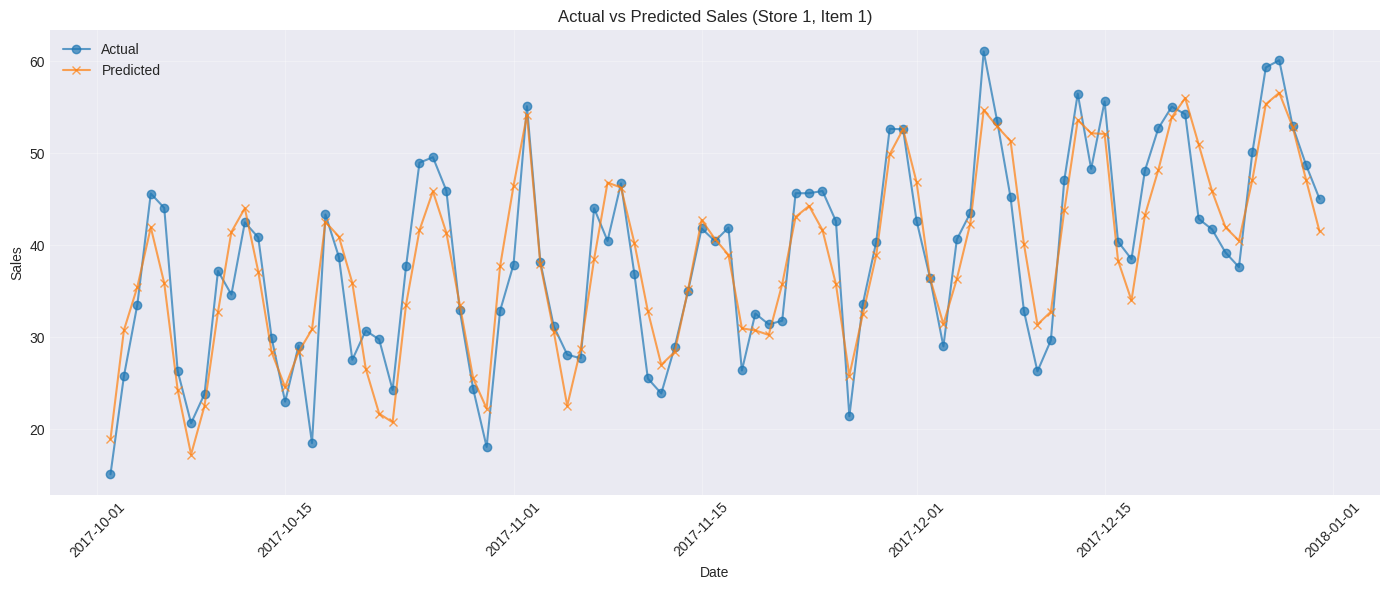

In [16]:
# 1つの店舗・商品の予測を可視化
sample_mask = (train_sorted['store'] == 1) & (train_sorted['item'] == 1)
sample_val_mask = sample_mask & val_mask

if sample_val_mask.sum() > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # 実測値
    dates_val = train_sorted.loc[sample_val_mask, 'date']
    actual_val = y_val[sample_val_mask.values[val_mask]]
    predicted_val = ensemble_preds[sample_val_mask.values[val_mask]]
    
    ax.plot(dates_val, actual_val, label='Actual', marker='o', alpha=0.7)
    ax.plot(dates_val, predicted_val, label='Predicted', marker='x', alpha=0.7)
    ax.set_title('Actual vs Predicted Sales (Store 1, Item 1)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 🎓 7. まとめ

### 学んだこと

1. ✅ 時系列データの基礎（Trend、Seasonality、ACF/PACF）
2. ✅ Lag features（過去データの活用）
3. ✅ Rolling window statistics（移動統計量）
4. ✅ Temporal split（時間分割）の重要性
5. ✅ GBDTで時系列予測
6. ✅ SMAPE評価指標

### さらに学ぶには

- **ノートブック20**: Optunaで最適化
- **ノートブック21**: SHAPで特徴量重要度分析
- **ノートブック24**: 時系列特徴量エンジニアリングの深掘り

---

**⏰ Happy Forecasting! 🎉**